# Spatial autocorrelation
This notebook measures the spatial autocorrelation of the psuedolableing strategies used in this work. Examples include per-concept, per-cluster and per-random label. 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [5]:
ID = 87#312

In [4]:
proc_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/gridsearch_results_final/k2processors/k12.processor"
proc = deserialize_model(proc_path)

In [5]:
from utils import construct_sprite
G_og = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S" + str(ID) + ".obj"
G_og = deserialize(G_og)
S = construct_sprite(G_og, proc, key_in="emb", key_out="concept")

In [6]:
S.nodes[0].keys()

dict_keys(['voronoi_polygon', 'cell_id', 'center_coord', 'cell_type', 'biomarker_expression', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER', 'emb', 'raw', 'concept'])

min/max values: 0 11
using extended colormap
unique cell types: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11]


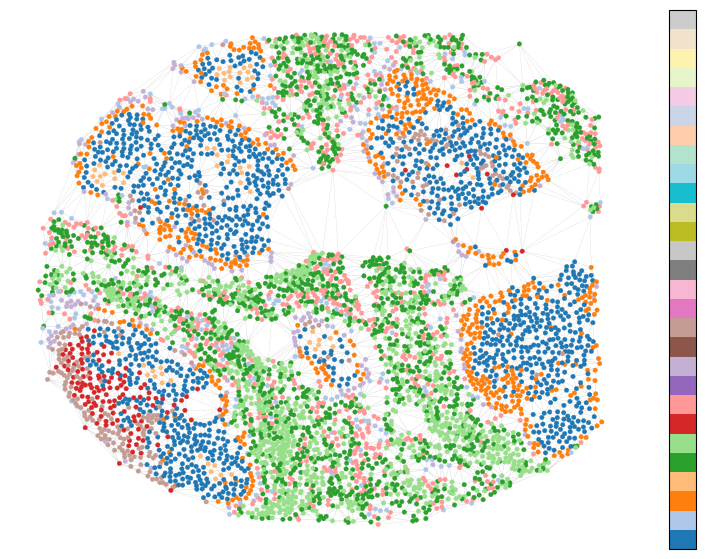

In [7]:
from utils import visualize_cell_graph
_ = visualize_cell_graph(S, key="concept", node_colors=None, edge_flag=True)

### Spatial autocorr using joint counts method
- convert to pysal/geopandas

In [8]:
from utils import convert_graph2df
df = convert_graph2df(S, key="concept")

In [9]:
df.head()

,x,y,concept
0,22.947266,483.373047,4
1,34.050781,470.789062,1
2,839.055664,1114.792969,7
3,833.133789,1115.903320,4
4,837.575195,1105.169922,7


In [8]:
import pandas as pd
import geopandas
geometry = geopandas.points_from_xy(df['x'], df['y'], df['concept'])
gdf = geopandas.GeoDataFrame(df, geometry=geometry)

NameError: name 'df' is not defined

In [11]:
import libpysal
from libpysal.weights import Queen, lag_spatial
from libpysal.weights import KNN  # Spatial weights matrix
from esda.join_counts import Join_Counts

w = Queen.from_dataframe(gdf, use_index=False)
# w = KNN.from_dataframe(gdf, k=8)

categorical = gdf['concept'].values

jcs = []
for C in set(categorical):
    y = (categorical == C).astype(int)
    jc = Join_Counts(y, w)
    jcs.append(jc)

In [12]:
for jc in jcs:
    print(jc.ww)

12470.0
16382.0
15130.0
17230.0
11397.0
12559.0
16848.0
14377.0
16740.0
16540.0


### Now we try the moran I method using hexbins

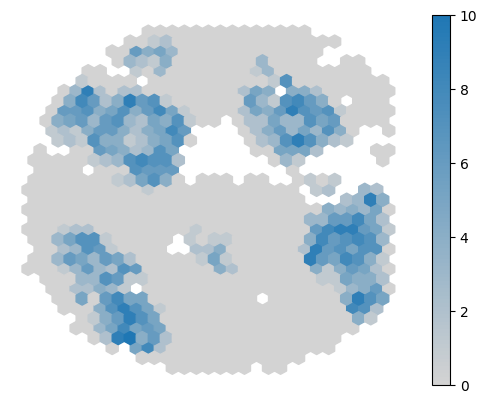

In [13]:
from utils import visualize_concept_density_hexbin
coll = visualize_concept_density_hexbin(S, concept=0, viz_flag=False)

In [14]:
offsets = coll.get_offsets()
arr = coll.get_array()

In [ ]:
offsets

array([[  12.21386609,  362.03992417],
       [  12.21386609,  491.01487822],
       [  12.21386609,  555.50235524],
       ...,
       [1094.23296005,  845.69600184],
       [1094.23296005,  910.18347886],
       [1094.23296005,  974.67095588]])

In [16]:
arr.data

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,
        0.,  0.,  2.,  6.,  0.,  0.,  0.,  2.,  3.,  3.,  2.,  0.,  0.,
        0.,  0.,  1.,  6.,  3.,  0.,  0.,  2.,  6.,  7.,  2.,  0.,  0.,
        0.,  4.,  7.,  9.,  0.,  3.,  4.,  4.,  3.,  6.,  0.,  0.,  0.,
        0.,  6.,  6.,  4.,  2.,  0.,  0.,  5.,  7.,  3.,  2.,  1.,  0.,
        0.,  0.,  0.,  5.,  6.,  5.,  0.,  0.,  8.,  9.,  1.,  7.,  0.,
        0.,  0.,  0.,  0.,  4.,  4.,  7.,  2.,  0.,  5.,  5.,  7.,  6.,
        0.,  0.,  0.,  0.,  7.,  2.,  2.,  4.,  2.,  1.,  6.,  8.,  6.,
        5.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  3.,  4.,  6.,  0.,  0.,
        4.,  0.,  2.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  7.,
        5.,  8.,  0.,  3.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  6.,  5.,  8.,  5.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  6.,  1.,  0.,  0.,  0.,  0

In [17]:
df2 = pd.DataFrame(offsets, columns=["x", "y"])
df2["concept"] = arr.data
df2.head()

,x,y,concept
0,12.213866,362.039924,0.0
1,12.213866,491.014878,0.0
2,12.213866,555.502355,0.0
3,12.213866,619.989832,0.0
4,48.892479,362.039924,0.0


In [18]:
geometry = geopandas.points_from_xy(df2['x'], df2['y'], df2['concept'])
gdf = geopandas.GeoDataFrame(df2, geometry=geometry)

In [19]:
from esda.moran import Moran
w = Queen.from_dataframe(gdf, use_index=False)
mi = Moran(gdf['concept'].values, w)

In [ ]:
mi.I

0.6951920204249894

### put it all together to get all stats

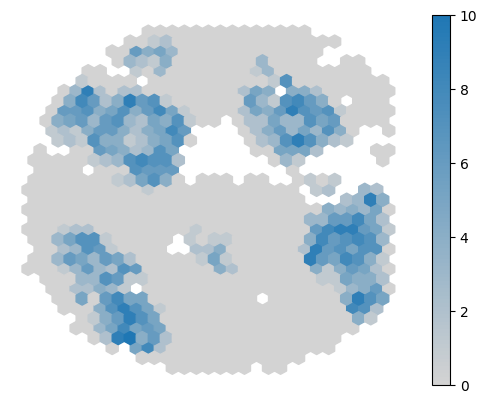

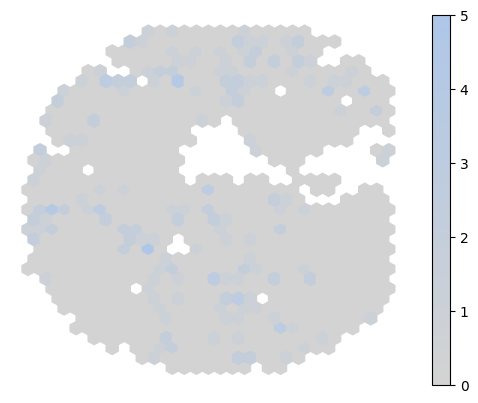

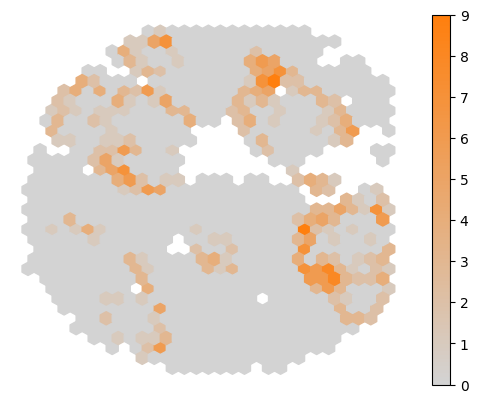

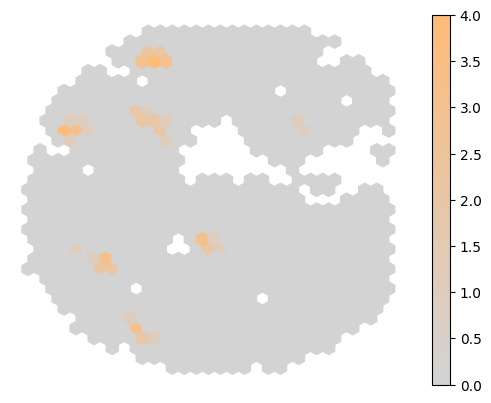

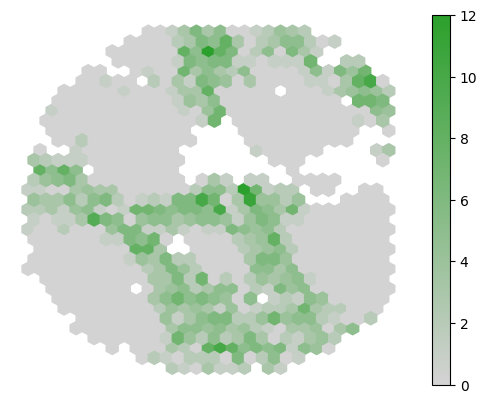

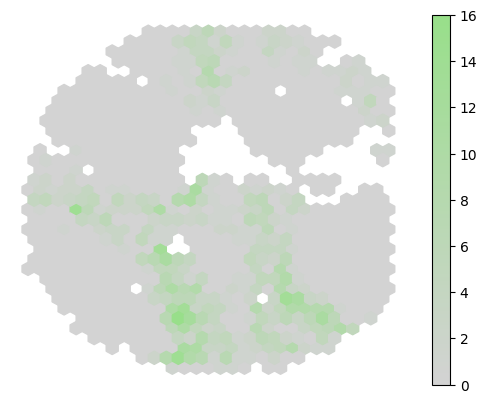

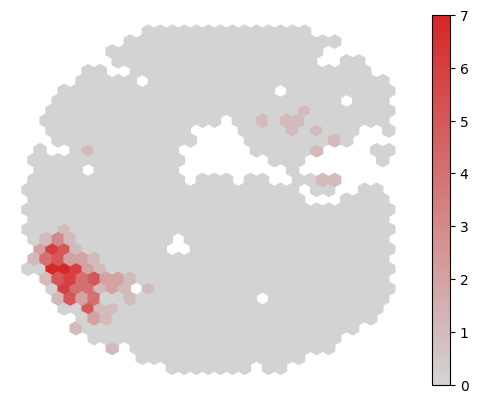

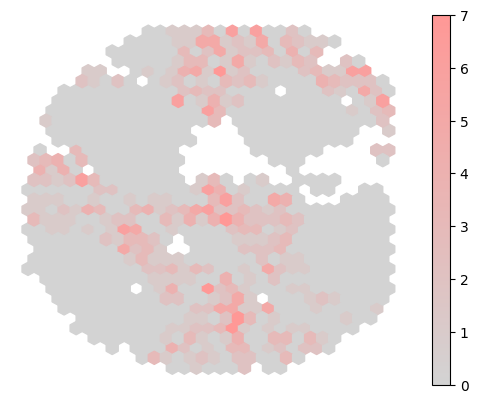

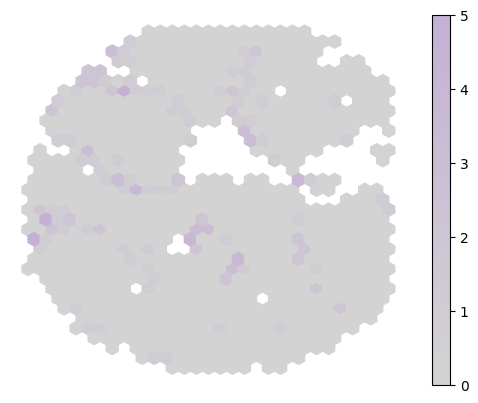

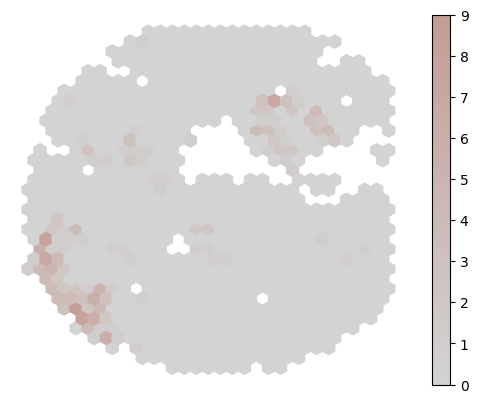

In [21]:
mis = []
for C in set(categorical):
    coll = visualize_concept_density_hexbin(S, concept=C, viz_flag=False)
    offsets = coll.get_offsets()
    arr = coll.get_array()
    df2 = pd.DataFrame(offsets, columns=["x", "y"])
    df2["concept"] = arr.data
    geometry = geopandas.points_from_xy(df2['x'], df2['y'], df2['concept'])
    gdf = geopandas.GeoDataFrame(df2, geometry=geometry)
    w = Queen.from_dataframe(gdf, use_index=False)
    mi = Moran(gdf['concept'].values, w)
    mis.append(mi.I)


In [ ]:
mis

[0.6951920204249894,
 0.1368954397188687,
 0.41018022511857394,
 0.36175587978772145,
 0.5499339088168035,
 0.5302576217404853,
 0.7128139147710201,
 0.32220881708410504,
 0.21590473852278194,
 0.5144958258777663]

### Now run over all samples
Take a look at `moran.py` and run it from terminal. This avoids the numerous hexbin figures that are generated to compute the moran statistics. This file generates a dictionary object that we can analyze next.

In [6]:
from utils import deserialize
moran_dict = deserialize("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/moran_dict_final.obj")
moran_dict[ID]

[0.6951920204249894,
 0.1368954397188687,
 0.41018022511857394,
 0.36175587978772145,
 0.5499339088168035,
 0.5302576217404853,
 0.7128139147710201,
 0.32220881708410504,
 nan,
 0.21590473852278194,
 nan,
 0.5144958258777663]

In [9]:
# convert to df
df = pd.DataFrame.from_dict(moran_dict, orient='index')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
233,0.146825,0.168510,0.551306,0.542502,0.316835,0.149914,NaN,0.416094,NaN,0.456571,0.067897,0.141409
188,0.482734,0.347153,0.445946,0.333832,0.185492,-0.002541,NaN,0.398436,NaN,0.207287,NaN,0.477787
58,0.584819,0.211505,0.495614,0.274477,0.587687,0.372436,0.312290,0.400138,-0.001341,0.275273,NaN,0.553113
264,0.543723,0.315823,0.757435,0.390656,0.474461,0.166375,0.727389,0.525133,NaN,0.203597,NaN,0.597309
41,0.317773,0.427736,0.282880,0.425447,0.319636,0.352924,NaN,0.277152,-0.001197,0.263957,0.529573,-0.013999


In [10]:
meds = df.mean()
stds = df.std()

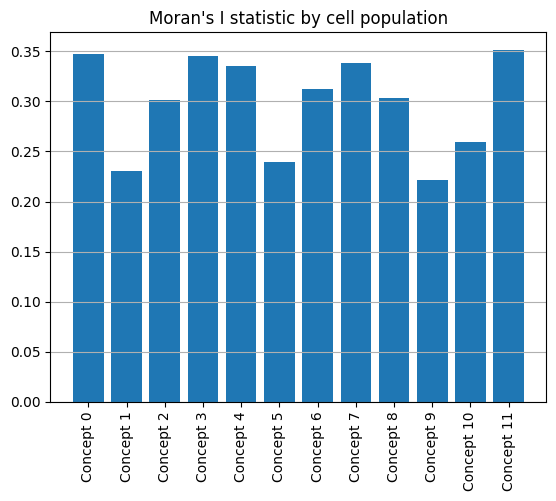

In [11]:
import matplotlib.pyplot as plt
plt.bar(meds.index, meds.values)
plt.xticks(meds.index, ["Concept "+str(s) for s in meds.index], rotation=90)
plt.title("Moran's I statistic by cell population")
plt.grid(axis="y")
plt.show()

### Now we check on K-means clusters on just raw expression

In [27]:
kmeans = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/kmeans_on_raw_final.obj")

In [28]:
ID = 87 # same example as above
G_og = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect/S" + str(ID) + ".obj"
G_og = deserialize(G_og)
S = construct_sprite(G_og, proc, key_in="emb", key_out="concept")

In [29]:
S.nodes[0].keys()

dict_keys(['voronoi_polygon', 'cell_id', 'center_coord', 'cell_type', 'biomarker_expression', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER', 'emb', 'raw', 'concept'])

In [30]:
kmeans.predict(S.nodes[0]["raw"].reshape(1, -1))

array([3], dtype=int32)

In [31]:
import networkx as nx
X = np.array(list(nx.get_node_attributes(S, "raw").values()))
print(X.shape)
cs = kmeans.predict(X)
cs.shape

(5903, 34)


(5903,)

now check the moran I file again to run code for clusters

In [12]:
moran_dict2 = deserialize("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/moran_dict_cluster_final.obj")
moran_dict2[ID]

[0.16818125189355285,
 0.311532278460432,
 0.39876781485107904,
 0.5223940570400358,
 0.1451933218123966,
 nan,
 0.35875403255468175,
 0.35544528361730027,
 0.06837190091808222,
 0.034735354996530604,
 0.5737964711930892,
 -0.002710355987055017]

In [13]:
df2 = pd.DataFrame.from_dict(moran_dict2, orient='index')
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11
233,0.132289,0.123922,0.206243,0.274971,0.095820,NaN,0.190542,0.139487,0.126740,0.095409,0.406701,0.032646
188,0.105157,0.073411,0.093381,0.422791,0.031774,-0.001181,0.099084,0.135837,0.120862,0.004192,0.383723,0.030696
58,0.140209,0.232741,0.377983,0.445753,0.107841,NaN,0.352777,0.333119,0.158512,0.100768,0.616239,-0.011685
264,0.325282,0.182812,0.297086,0.407648,0.003778,NaN,0.378083,0.225034,0.107138,0.079338,0.525565,-0.015298
41,0.115485,0.219012,0.232333,0.331825,0.072845,-0.007176,0.119058,0.200421,0.117716,0.009922,0.362694,0.018251


In [14]:
meds2 = df2.mean()
stds2 = df2.std()

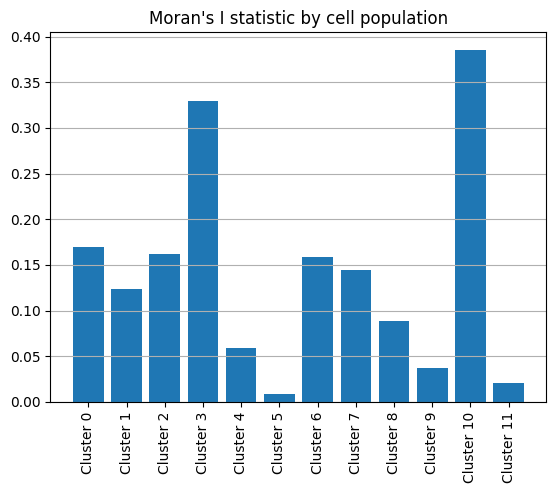

In [15]:
import matplotlib.pyplot as plt
plt.bar(meds2.index, meds2.values)
plt.xticks(meds2.index, ["Cluster "+str(s) for s in meds2.index], rotation=90)
plt.title("Moran's I statistic by cell population")
plt.grid(axis="y")
plt.show()

In [36]:
list(range(2*len(meds.index)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

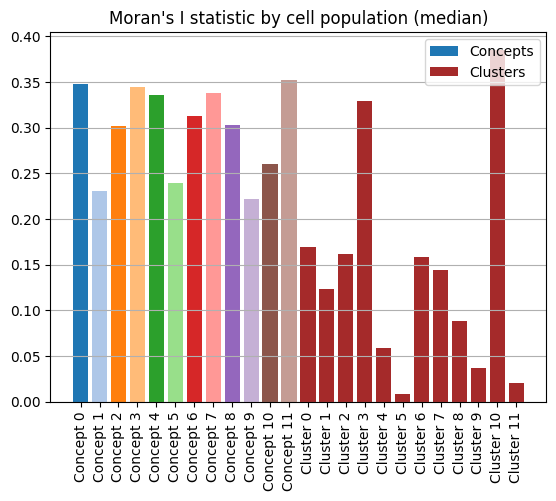

In [16]:
import matplotlib.pyplot as plt

from matplotlib import cm, colors
joint_cmap = colors.ListedColormap(cm.tab20.colors + cm.Pastel2.colors, name='tab40')
joint_cmap.set_bad(color='lightgray') #used to be white
cs = [joint_cmap(i) for i in list(range(len(meds.index)))]

plt.bar(list(range(len(meds.index))), list(meds.values), color=cs)
plt.bar(list(range(len(meds.index), len(meds.index)+len(meds2.index))), list(meds2.values), color="brown")
plt.xticks(list(range(2*len(meds.index))), ["Concept "+str(s) for s in meds.index] + ["Cluster "+str(s) for s in meds2.index], rotation=90)
plt.title("Moran's I statistic by cell population (median)")
plt.legend(["Concepts", "Clusters"])
plt.grid(axis="y")
plt.show()

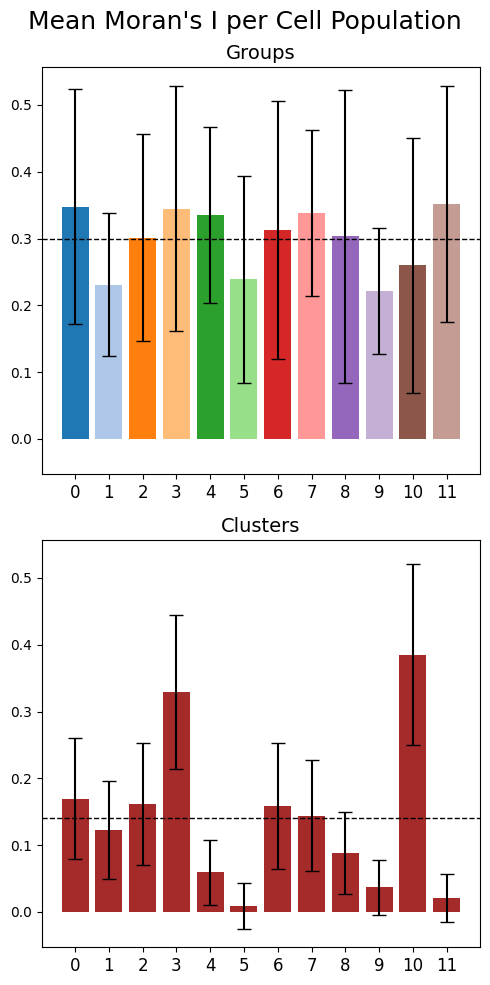

In [17]:
import matplotlib.pyplot as plt

# Example data (replace meds and meds2 with your actual data)
meds_dict = dict(zip(list(range(12)), meds))
meds2_dict = dict(zip(list(range(12)), meds2))
            
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(5,10))

# First bar plot
ax1.bar(list(range(len(meds))), list(meds_dict.values()), color=cs, yerr=stds, capsize=5)
ax1.set_xticks(list(range(len(meds))))
ax1.set_xticklabels([str(s) for s in meds_dict.keys()], rotation=0, fontsize=12)
ax1.set_title("Groups", fontsize=14)
# ax1.tick_params(axis='y', which='major', labelsize=12)
# add a horizontal line as mean of the meds values
ax1.axhline(meds.mean(), color='k', linestyle='dashed', linewidth=1)

# Second bar plot
ax2.bar(list(range(len(meds2))), list(meds2_dict.values()), color="brown", yerr=stds2, capsize=5)
ax2.set_xticks(list(range(len(meds2))))
ax2.set_xticklabels([str(s) for s in meds2_dict.keys()], rotation=0, fontsize=12)
ax2.set_title("Clusters", fontsize=14)
# add a horizontal line as mean of the meds values
ax2.axhline(meds2.mean(), color='k', linestyle='dashed', linewidth=1)
ax2.set_xlim(ax1.get_xlim())

# Shared y-axis label
fig.suptitle("Mean Moran's I per Cell Population", fontsize=18)
# ax1.grid(axis="y")
# ax2.grid(axis="y")

plt.tight_layout()
plt.show()